# Standby consumption analysis

OpenGrid has a standby consumption analysis. This analysis will extract the minimum consumption during a specified period of the day. By default, the minimum over the entire day is found, but the method can be tuned to analyse eg. only the night. 

### Imports and loading data

In [1]:
import opengrid as og
from opengrid.library import plotting as og_plot
import pandas as pd
from joule import meta, filter_meta

In [2]:
plt = og.plot_style()
#%matplotlib notebook

In [3]:
#%matplotlib notebook

For a correct standby power analysis **we need high-resolution data, eg. minute-values**.  With hourly values we would often overestimate the real standby power as fridges, freezers or other intermittent short loads are included in the hourly consumption measure.  

In this demo we use electricity consumption data with 1-minute resolution for a single sensor. First, we load the dataframe and make a quick plot to show the data.

In [4]:
# If resolution is 1 minute:
# factor = 60;
# If resolution is 15 minutes:
factor = 4;

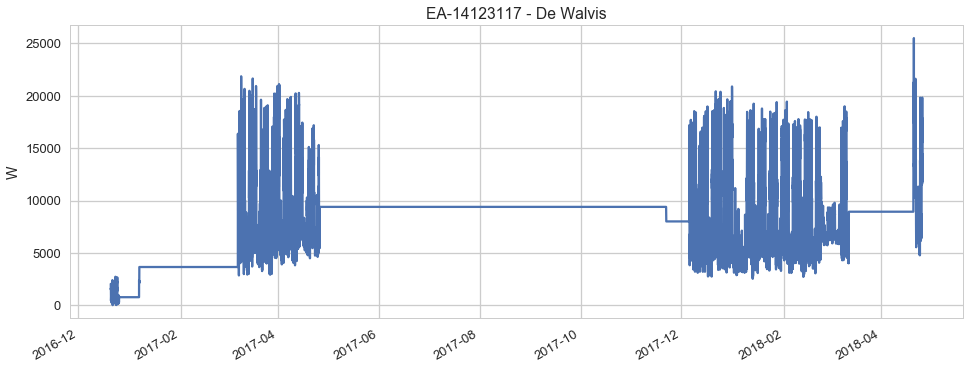

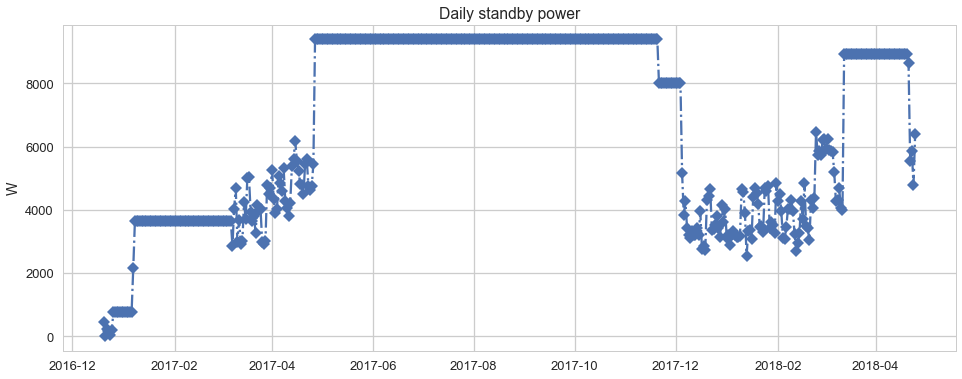

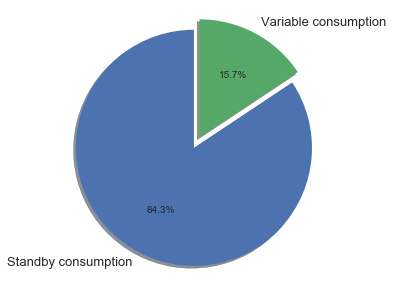

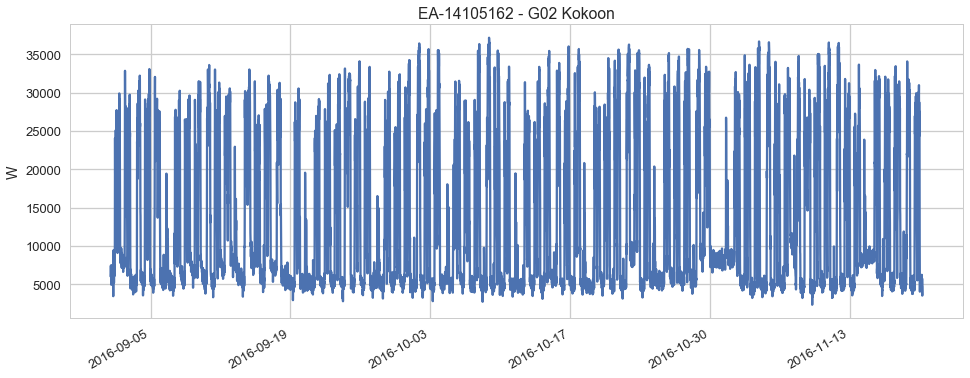

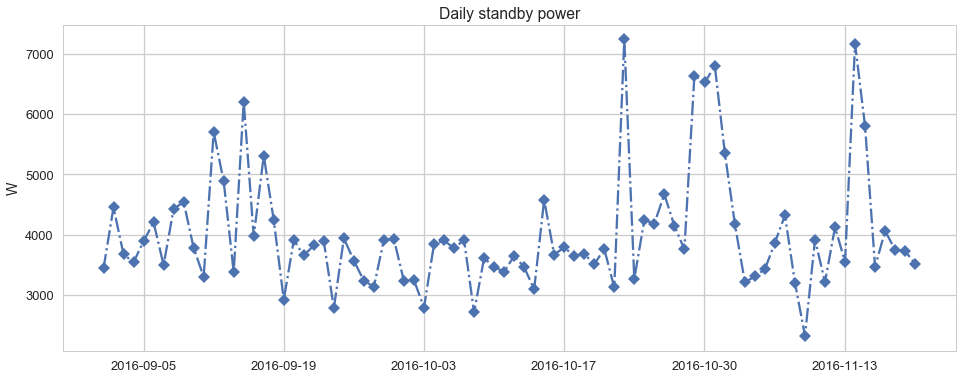

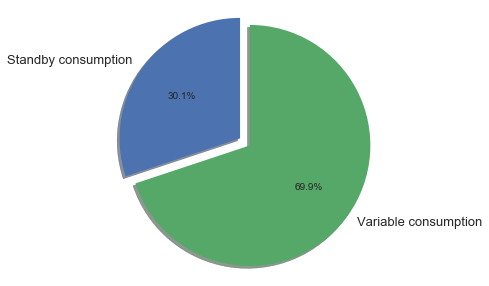

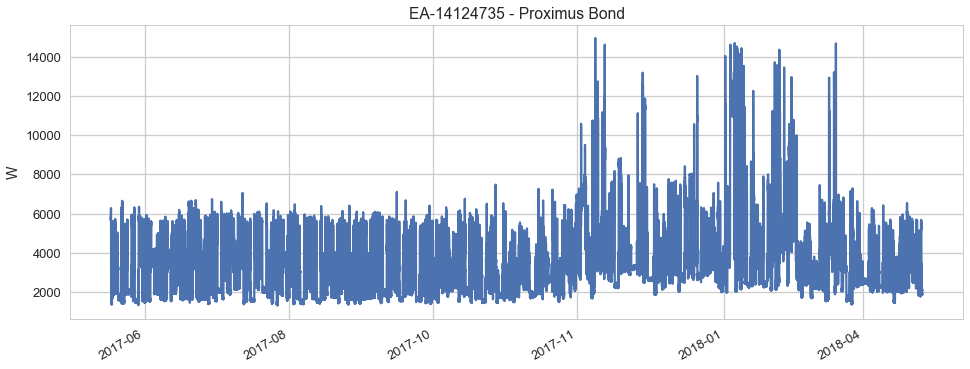

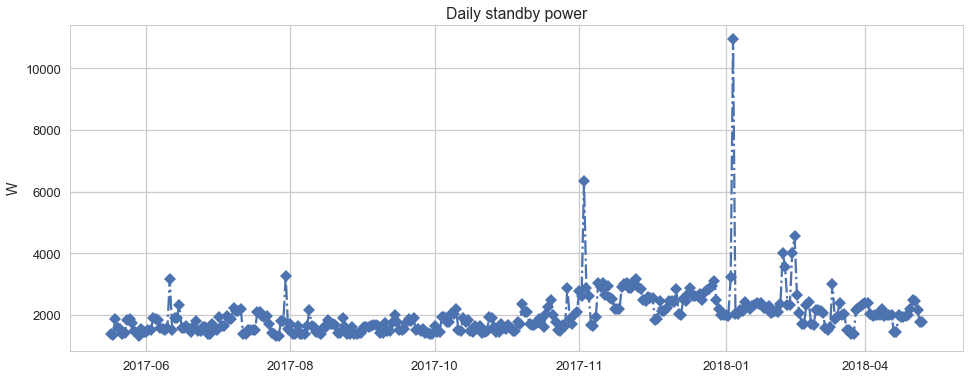

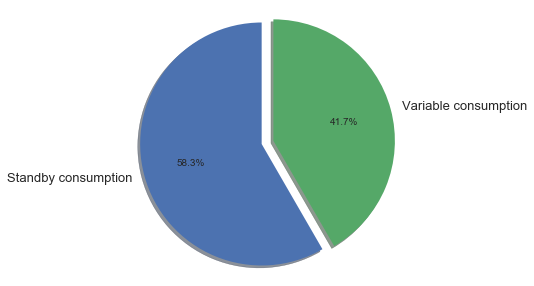

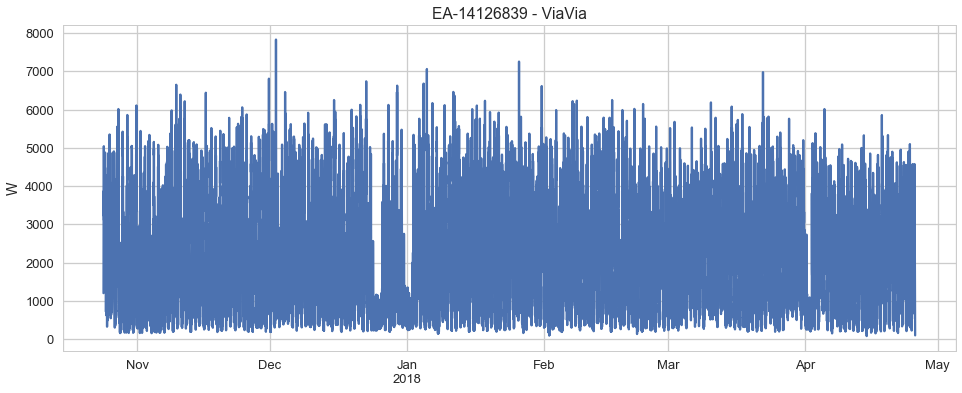

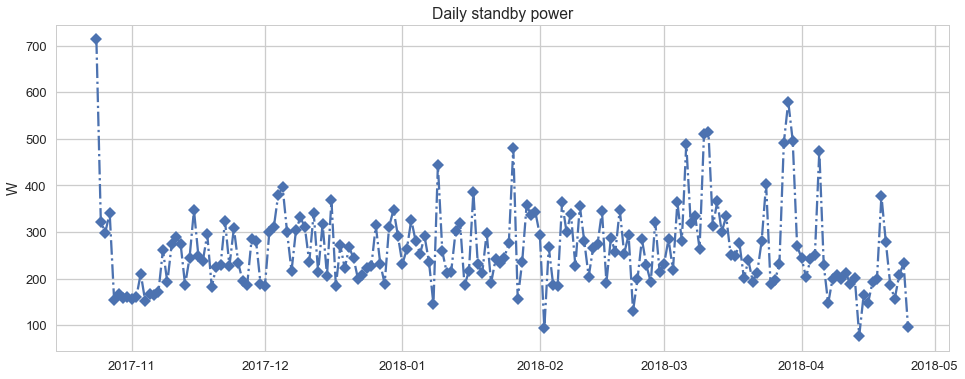

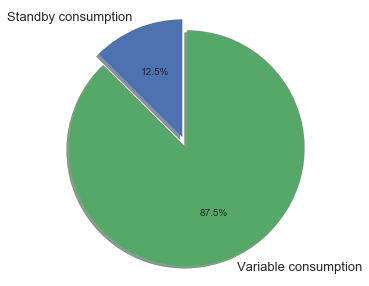

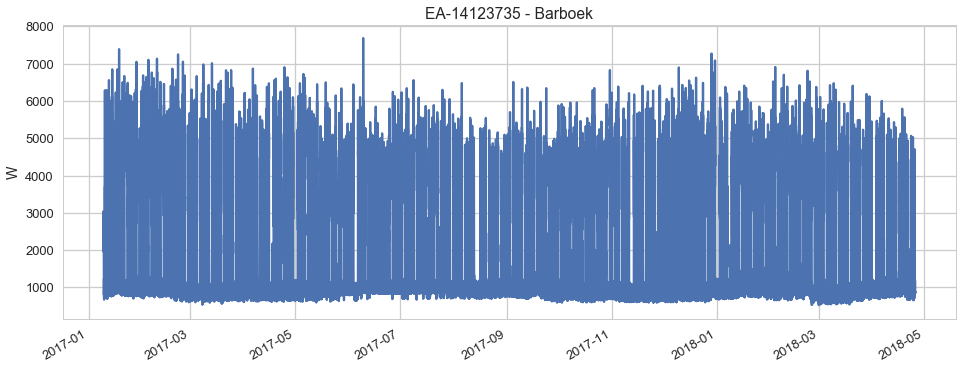

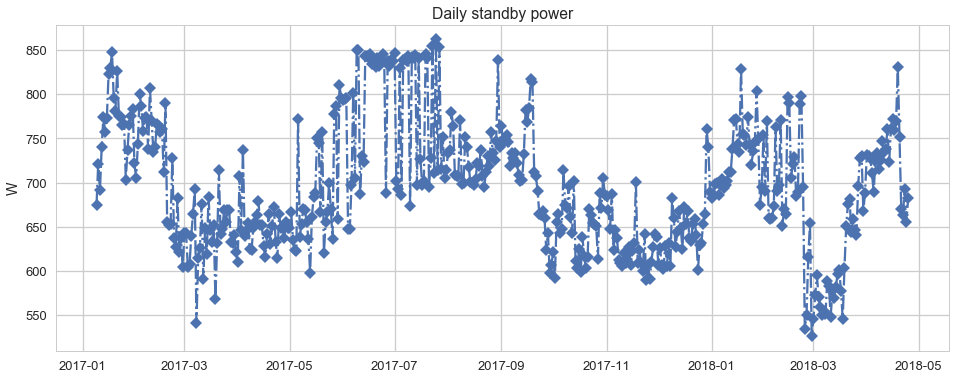

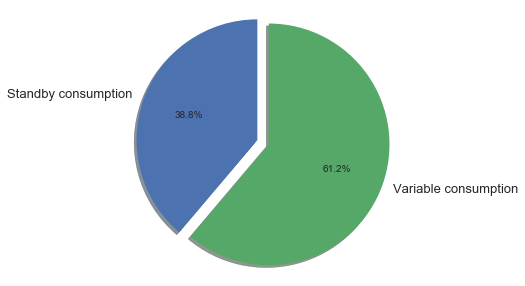

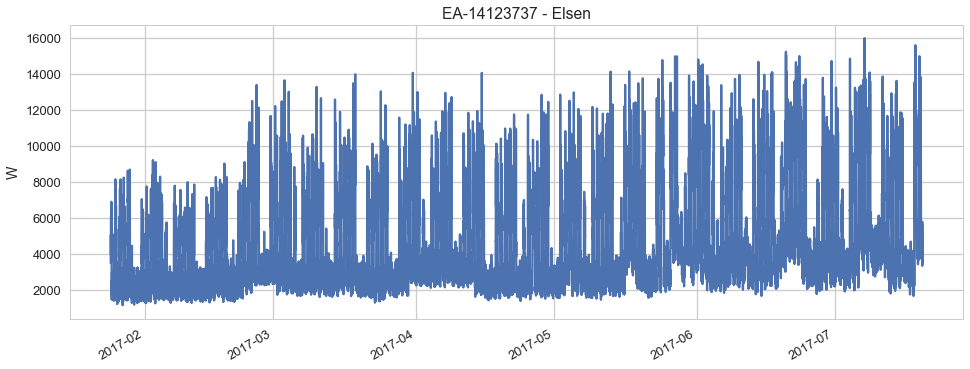

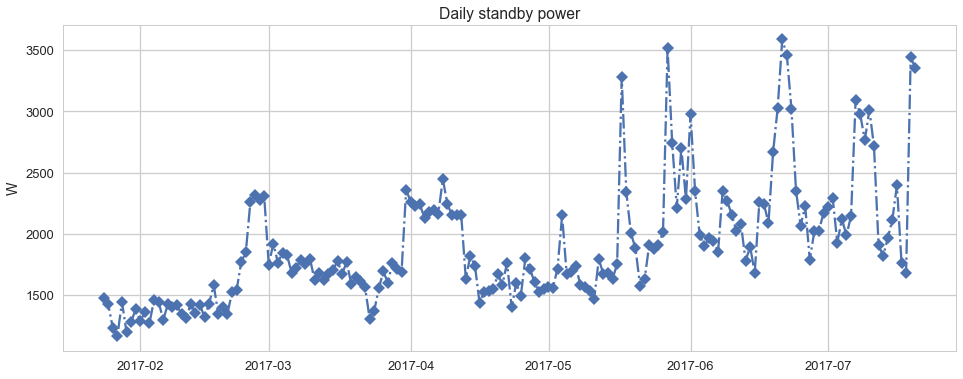

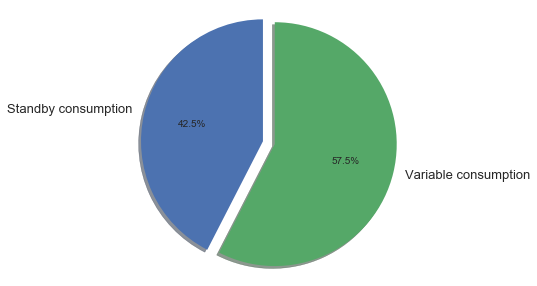

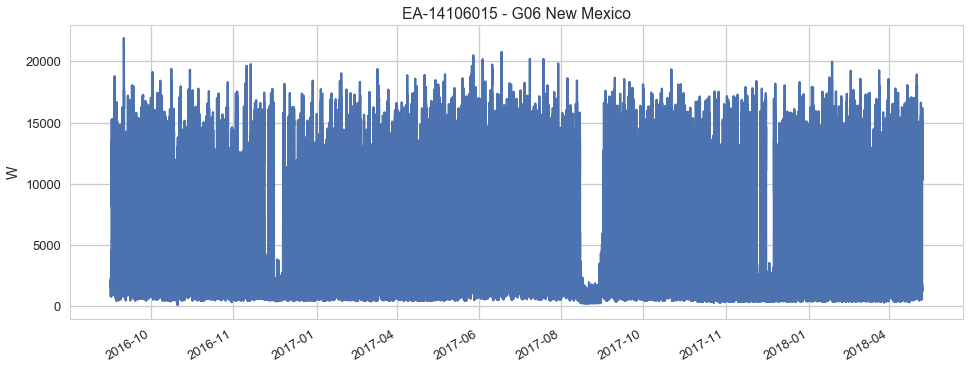

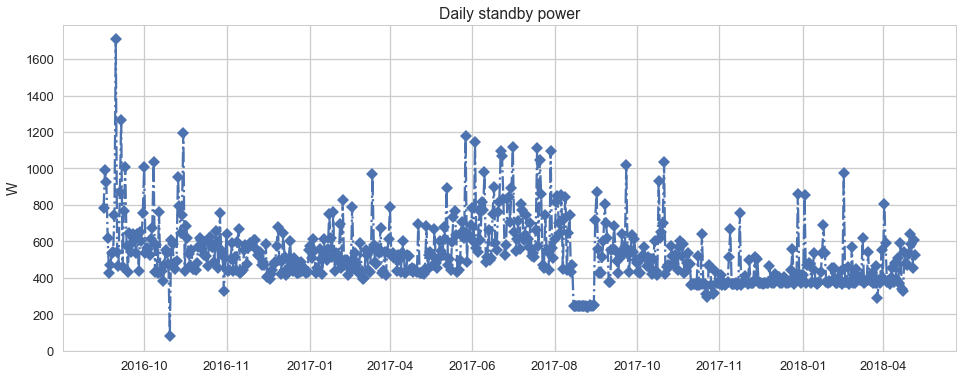

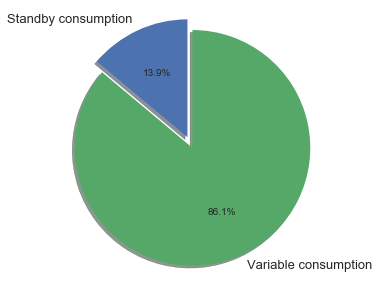

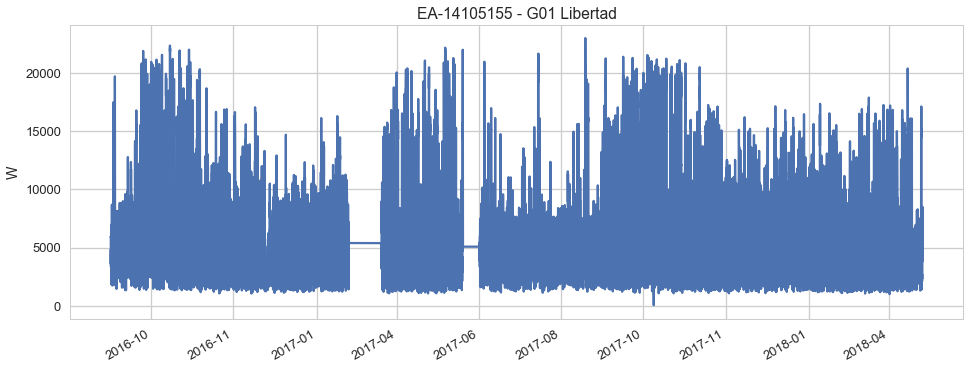

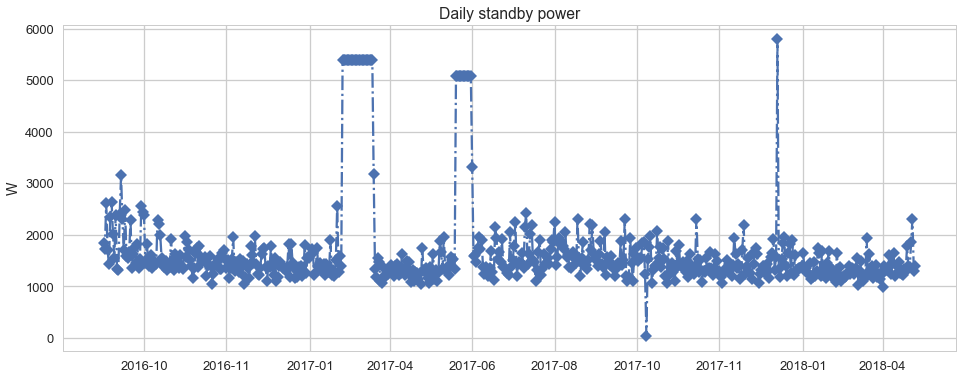

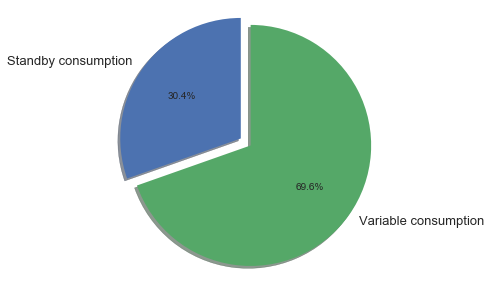

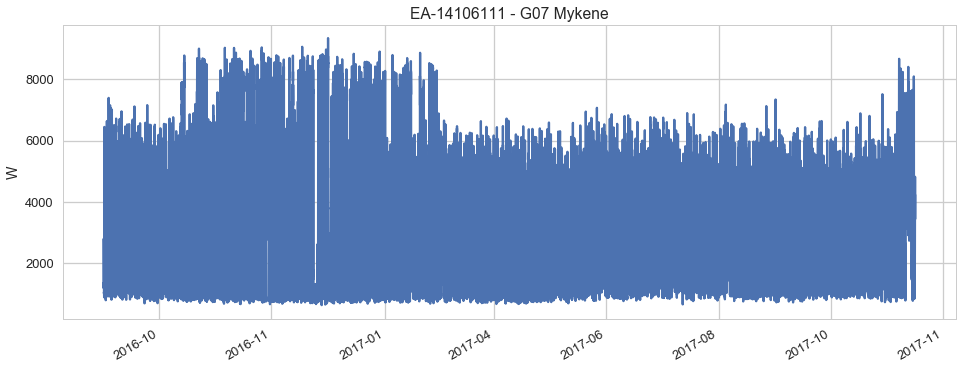

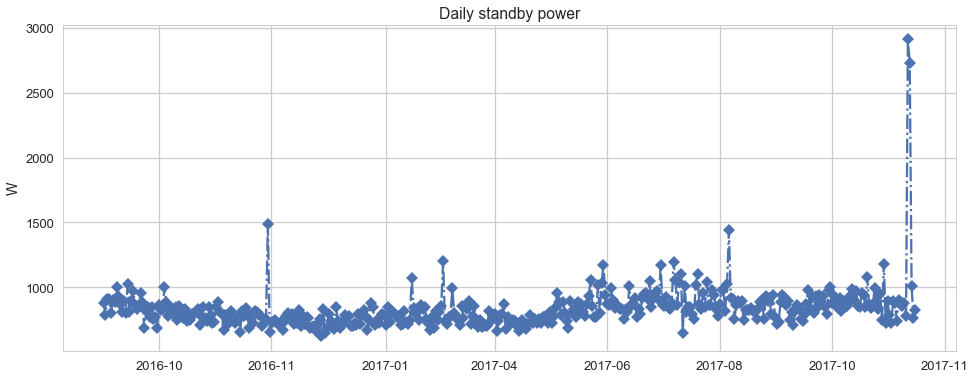

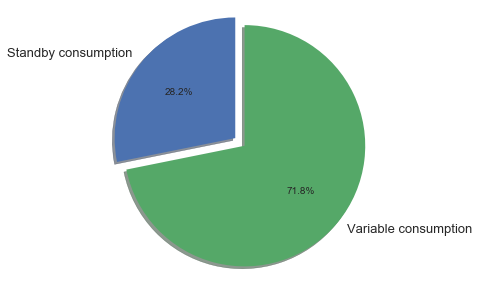

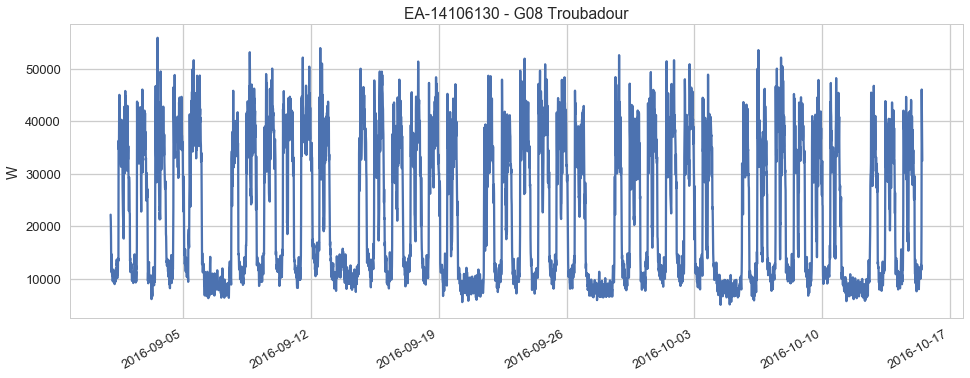

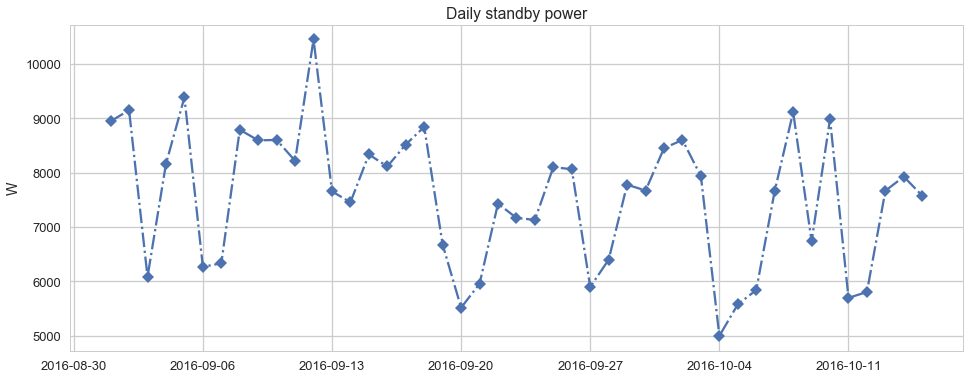

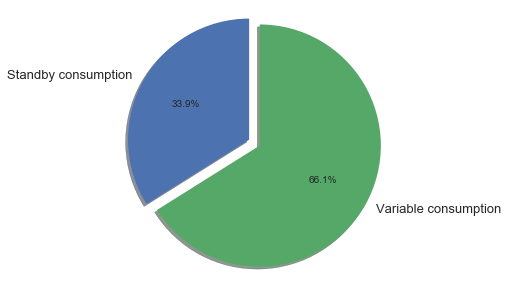

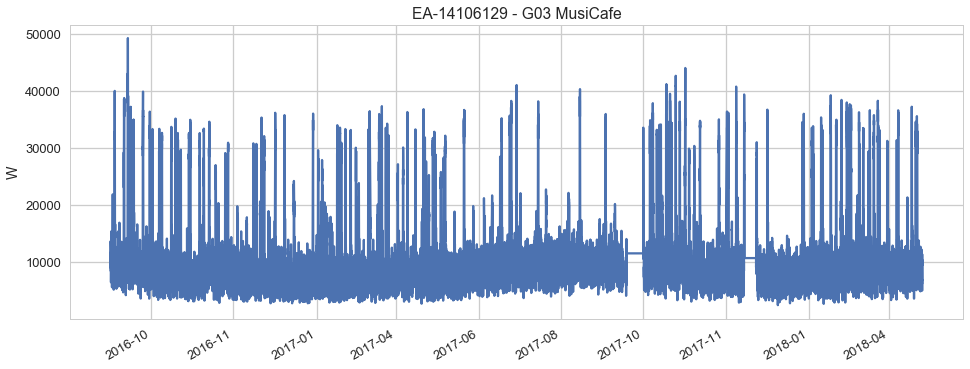

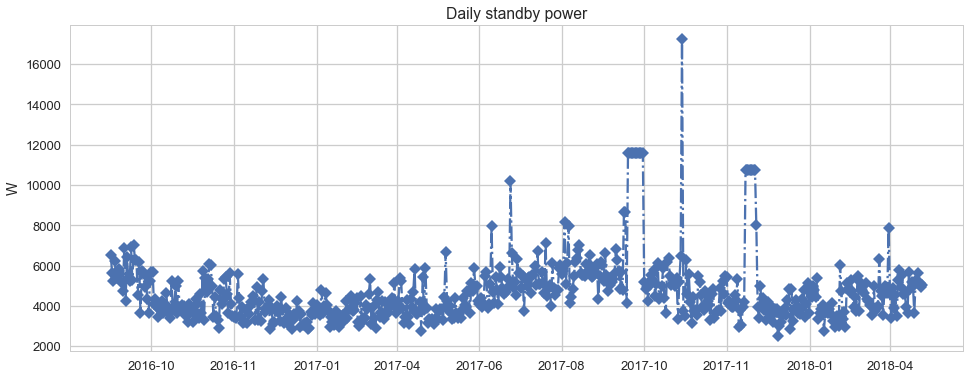

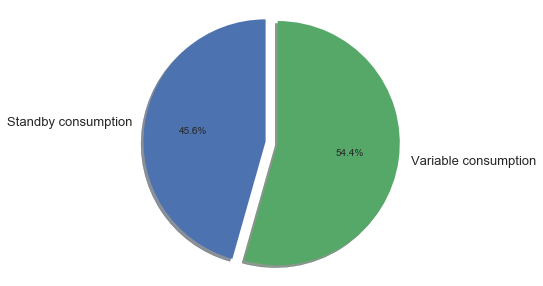

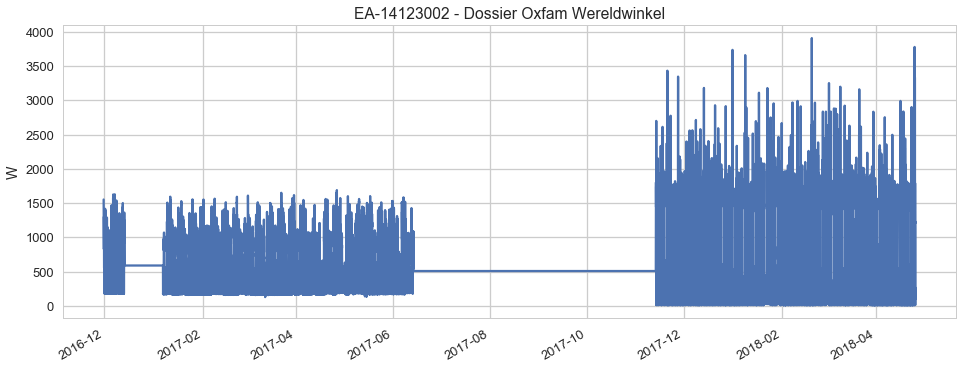

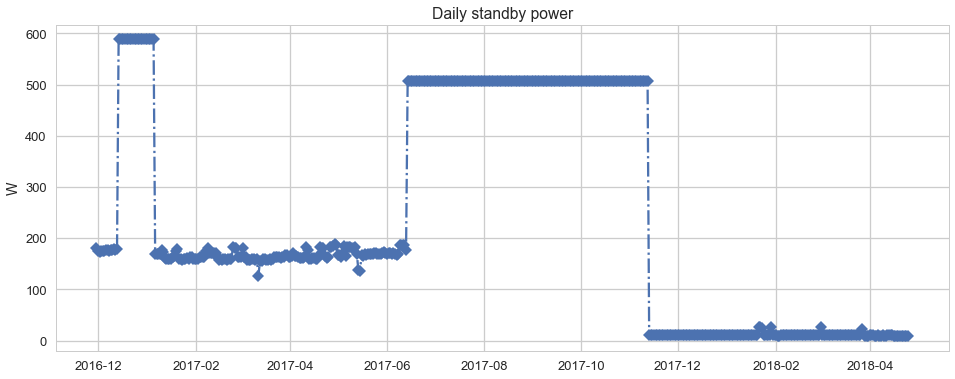

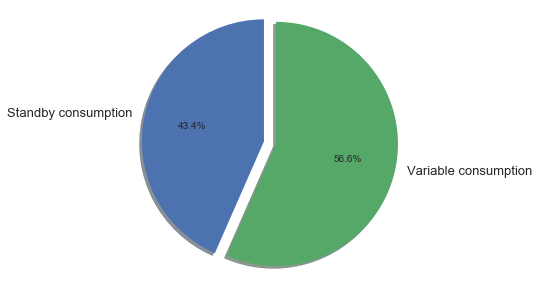

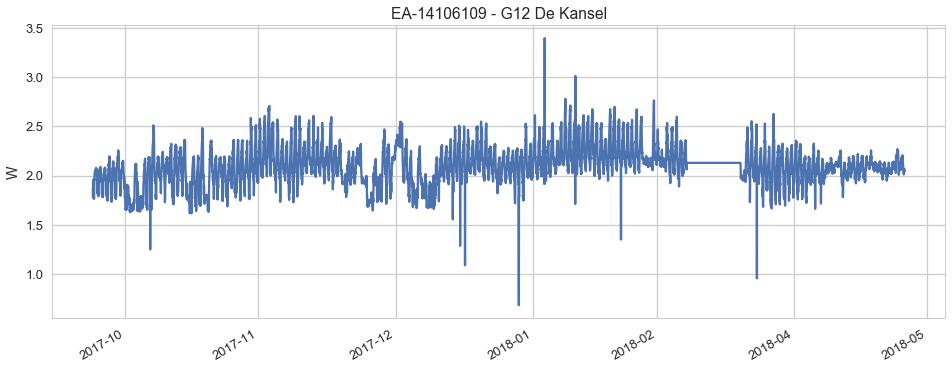

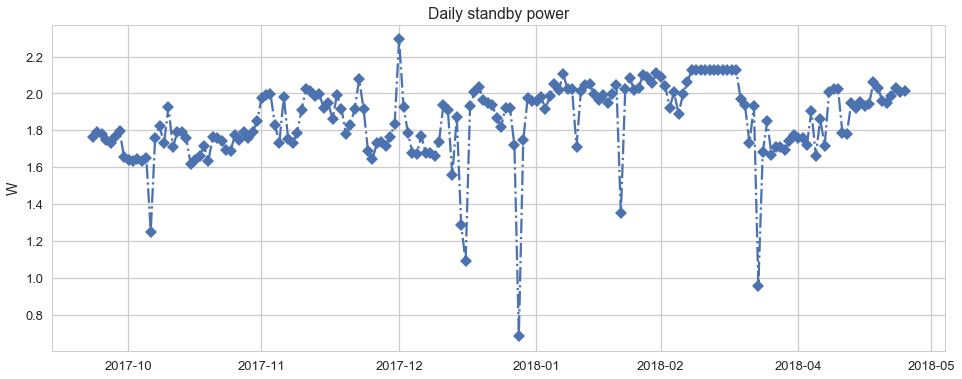

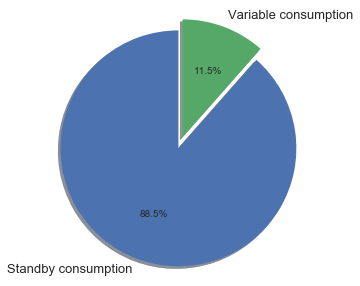

In [5]:
for building in meta['RecordNumber'].unique():
    ts = pd.read_pickle('data/Electricity_{}.pkl'.format(building)).sum(axis=1)*factor
    if not ts.empty:
        ax = ts.plot()
        ax.set_ylabel('W')
        plt.title('{} - {}'.format(building, filter_meta(RecordNumber=building)['RecordName'].iloc[0]))
        plt.show()
        
        
        standby_all = og.analysis.standby(ts) # returns a pandas Series
        fig = plt.plot(standby_all.index, standby_all.values, marker='D', linestyle='-.', label='all day')
        plt.title('Daily standby power')
        fig[0].axes.set_ylabel('W')
        plt.show()
        
        
        share_standby = og.analysis.share_of_standby(ts)
        fig1, ax1 = plt.subplots(figsize=(5,5))
        ax1.pie([share_standby, 1-share_standby], 
        explode=(0.1, 0), 
        labels=['Standby consumption', 'Variable consumption'], 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  """Entry point for launching an IPython kernel.


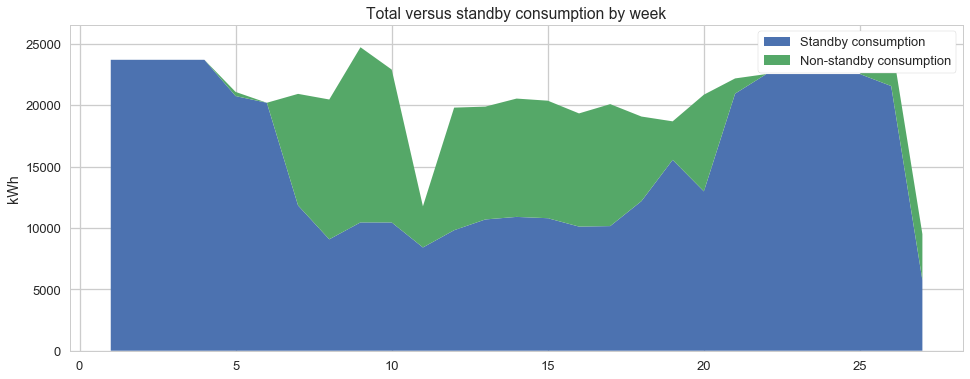

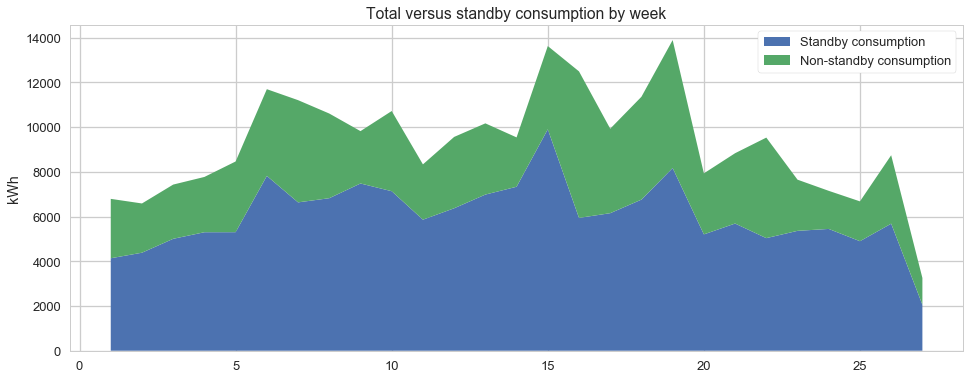

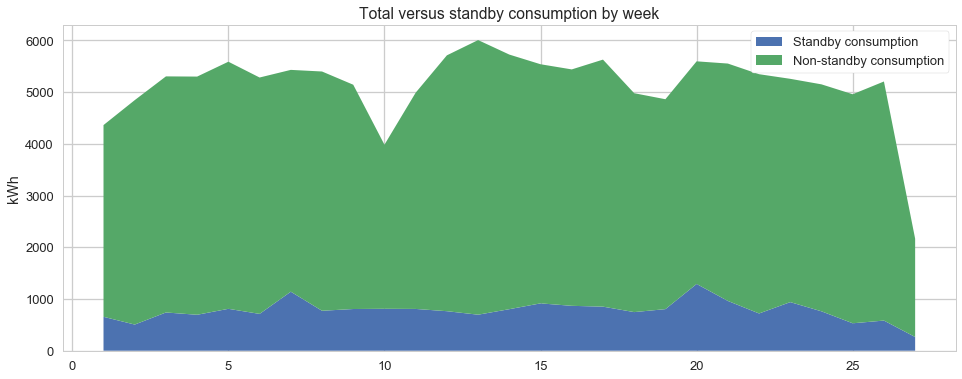

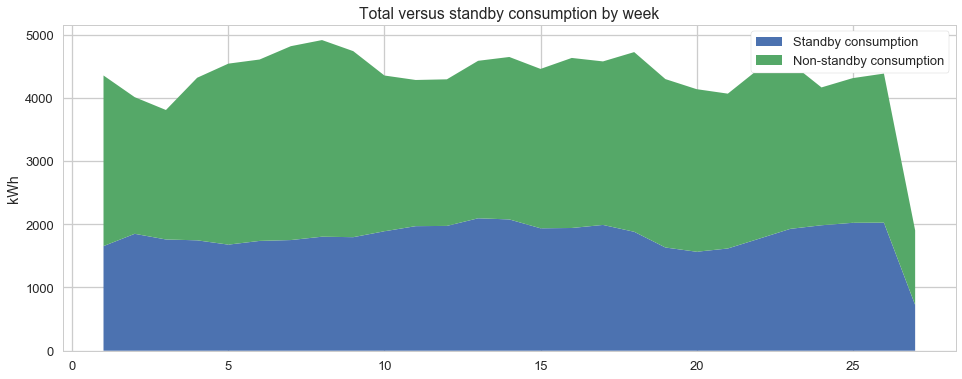

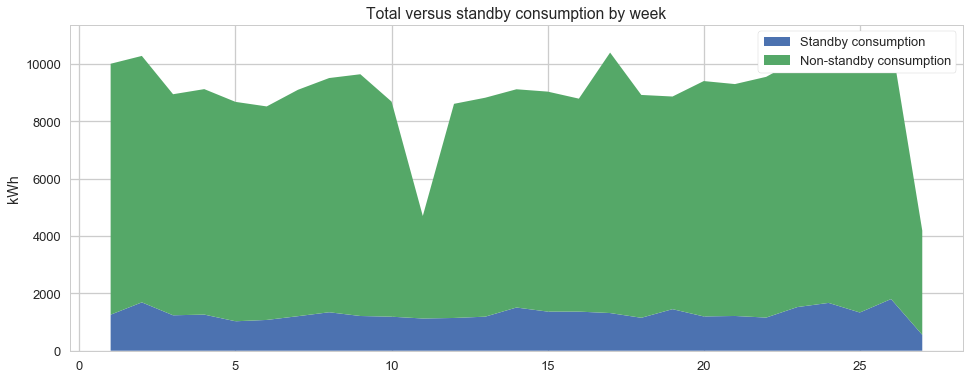

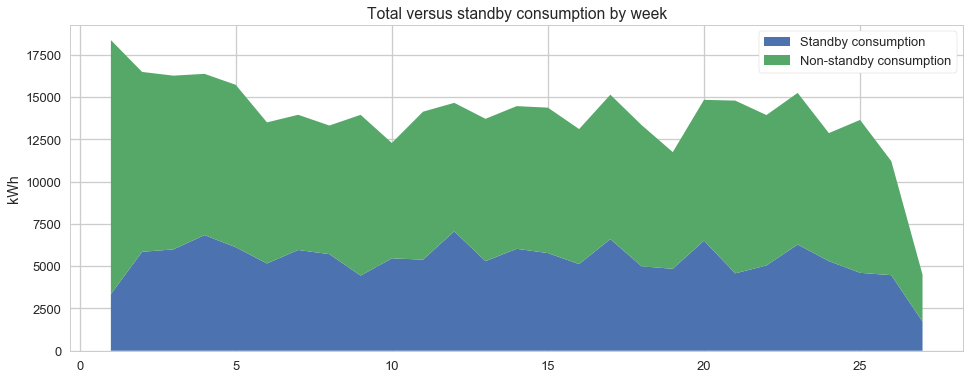

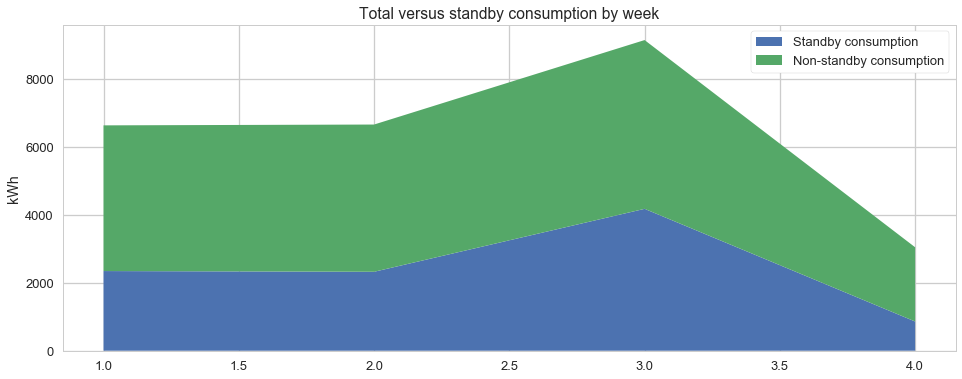

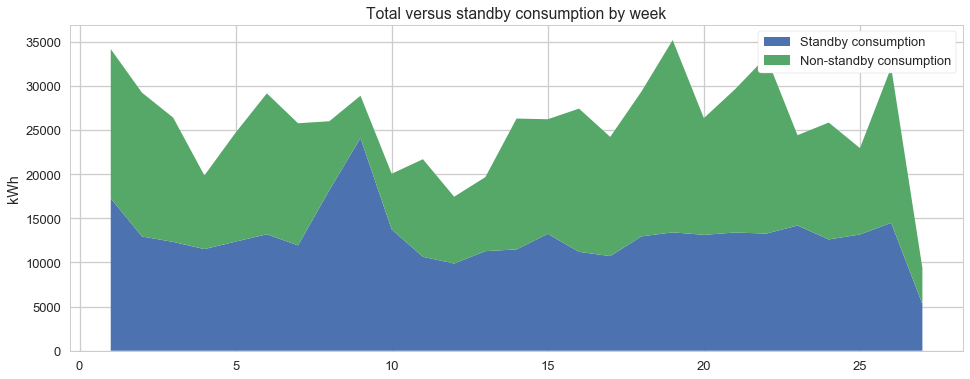

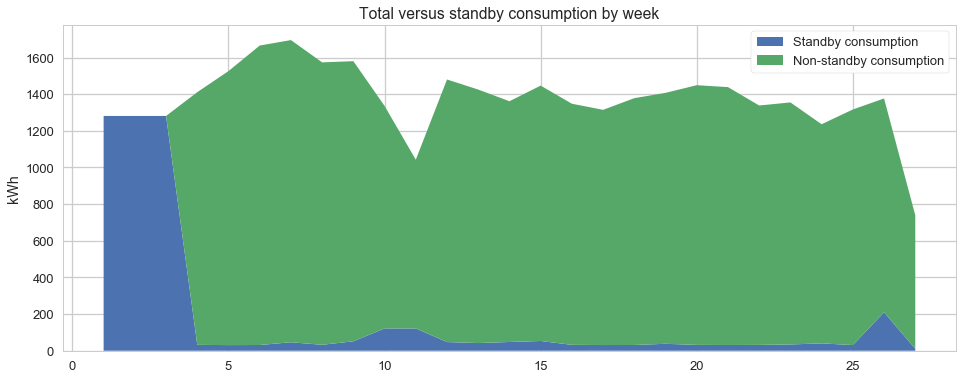

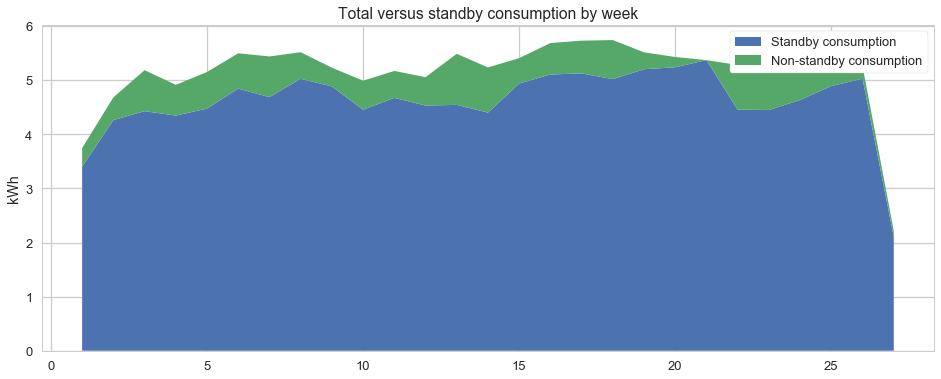

In [6]:
weekly_index = standby_all.resample('W-MON', label='left').index
df_boxplot = pd.DataFrame(index=weekly_index,
                  columns = meta['RecordNumber'].unique())

for building in meta['RecordNumber'].unique():
    df_stack = pd.DataFrame(index=weekly_index,
                  columns = ['Variable', 'Standby'])
    ts = pd.read_pickle('data/Electricity_{}.pkl'.format(building)).sum(axis=1)*60 # in W, minute resolution
    
    for i in df_boxplot.index:
        ts_week = ts.loc[i:i+pd.Timedelta(days=7)]
        if not ts_week.empty:
            share_of_standby = og.analysis.share_of_standby(ts_week)
            df_boxplot.loc[i,building] = share_of_standby
            
            # Computations for the stacked plot
            total = ts_week.sum()/factor/1000 # kWh
            standby = share_of_standby * total
            df_stack.loc[i, 'Variable'] = total - standby
            df_stack.loc[i, 'Standby'] = standby
    # Plot
    if not df_stack.dropna().empty:
        df_stack = df_stack.applymap(float)
        plt.stackplot(range(1, 1+len(df_stack)), df_stack['Standby'], df_stack['Variable'], labels=['Standby consumption', 'Non-standby consumption'] )
        plt.legend()
        plt.ylabel('kWh')
        plt.title('Total versus standby consumption by week')
        fig = plt.gcf()
        fig.savefig("figures/stacked_consumption_by_week_" + building + ".png")
        plt.show()
        
            
df_boxplot.index = df_boxplot.index.map(lambda x: x.strftime('%Y-%m-%d'))
df_boxplot = df_boxplot.dropna(axis=1)

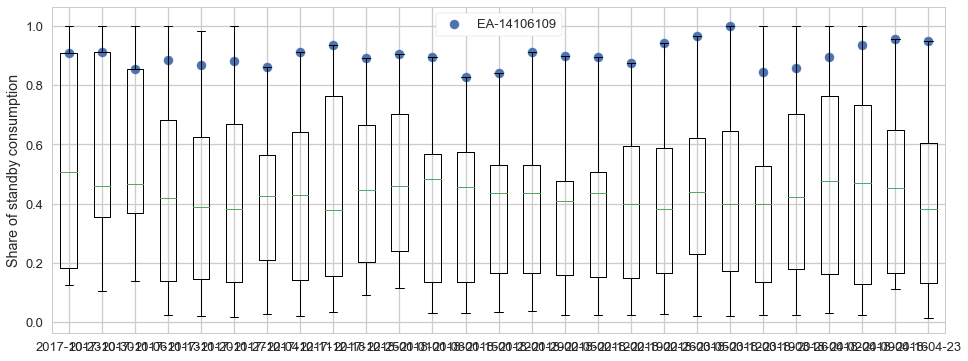

In [9]:
for col in df_boxplot.columns:
    fig = og_plot.boxplot(df=df_boxplot, plot_mean=False, plot_ids=[col], ylabel='Share of standby consumption')
    fig.savefig("figures/boxplot_" + col + ".png")